In [11]:
#TODO: save state while in progress
#TODO: save outputs in a way that means tree can be ordered afterwards


################################################
### set these parameters for the simulations ###
################################################

### do we want to incude delays?
delay=false # should we do ODEs or DDEs?

### Simulaton size
numCells=5 # number of starting cells
maxTimeTC=float(60*120) # how long should the entire simulation run
maxGens=3 # maximum number of gens in total
startGen=1 # what gen to start out
preSimTime=60*90
mechanicalDeathTime=3*60 #if the cell dies this soon ignore it and try again


### Heterogeneity stuff
distribute=true # should we distribute starting parameters for each founder cell
runPreCourse=false #should we run a time course to de-synchronise the cells.
preCV=0.11 # how much should we distribute starting parameters for each cell
preConcCV=32 # how much should we distriubte the starting concentrations for each cell
divCV=0.072 # CV of asymmetric division

### IKK stuff
totalIKK=200 #total IKK, IKK activity then scales between 0 and 100% of this alue
basalIKK=totalIKK/100 # 1% at basal and at steady state phase
#IKKMultiplier=1 # this can be used to scale IKK
IKKMultiplier=1 # this can be used to scale IKK
#paramVals=[0,2,  7,13,19,32, 29, 27, 25, 24,  22,  22, 22]./100

paramTime=[0,15,30,45,60,90,120,240,360,600,1440,3000,maxTimeTC]
#paramVals=[0,5,  10,13,19,32, 29, 27, 25, 20,  14,  12, 10]./100
paramVals=[1, 2, 7, 13, 19, 32, 29, 27, 25, 24, 22, 20, 19, 14, 11, 5, 1]./100
paramTime=[0, 15, 30 , 45, 60, 90, 120, 240, 360, 600, 1440, 1440*2, 1440*3, 1440*4, 1440*5, 1440*6, 1440*10]


### plotting parameters
plotSpacing=25 # how to space out the lineage tree
crossSize=5

################################################
########## set these file locations ############
################################################
### set up where CSV2Julia is
locationOfCSV2Julia="csv2Julia/csv2model.py"
### set up where steady-state values are, from inidividual models
### these are used as initial conditions for the big model
nfkbSSFile="initialConditions/nfkbSteadyState.csv"
apoptosisFile="initialConditions/apopSteadyState.csv"
linkingFile="initialConditions/linkInitConds.csv"
moduleDefinitionFilesFolder="moduleDefinitionFiles/"

################################################
### all the packages we need are defined here ##
################################################
using Logging
using Dates
using CSV
using DataFrames
using JLD2
using DifferentialEquations, DataFrames
using Plots 
using CSV
using Distributions
using Random
using SmoothingSplines
import Base.Threads
import Base.Threads.@spawn

#we need this function to fix species
include("utilityFunctions/fixSpecies.jl")

#keep things reproducible by setting the seed
Random.seed!(123)

################################################
######### Global variables we need #############
################################################
#colour for output plot
thisColorPalette=palette(:seaborn_colorblind,maxGens)

# store every cell in this array.
cells=[];

println("starting simulation with "*string(Threads.nthreads())*" threads.")

starting simulation with 64 threads.


In [12]:
################################################
#### clean up folders from previous runs #######
################################################
distributedCombinedModelLocation="distrbutedCombinedModelDefinitionFiles/"
if isfile("graphStructure.csv")
    dateStamp=Dates.now()
    mv("graphStructure.csv","$(dateStamp)-graphStructure.csv")
end
if isfile("cellCounts.csv")
    dateStamp=Dates.now()
    mv("cellCounts.csv","$(dateStamp)-cellCounts.csv")
end
if isdir(distributedCombinedModelLocation)
    dateStamp=Dates.now()
    mv(distributedCombinedModelLocation,"$(dateStamp)-"*distributedCombinedModelLocation)
end
println("Any old folders moved and saved with date stamp.")

Any old folders moved and saved with date stamp.


In [13]:
################################################
######### Set up logging to a log file #########
################################################
# Open a textfile for writing the entiure log too as we clear output
fileNameLog=string(Dates.now())*"_log.jl"
io = open(fileNameLog, "w+")
logger = SimpleLogger(io)
global_logger(logger)
@info("simulation started at: " * string(Dates.now())); flush(io)
println("set up logging to: "*fileNameLog)

set up logging to: 2021-10-14T11:27:44.046_log.jl


In [14]:
################################################
####### define the distributions we need #######
################################################
function sampleInit(y0,cv)
    #note mean of distribution is 1 so CV = standard deviation
    distribution=Truncated(myLogNormal(1,cv),0,Inf)
    scaling=rand(distribution, 1)
    scaling=scaling[1]
    ynew=y0.*scaling
    scalingInv=1+(1-scaling)
    ynewinv=y0.*scalingInv
    return abs.(ynew), abs.(ynewinv)
end
function myLogNormal(m,std)
    γ = 1+std^2/m^2
    μ = log(m/sqrt(γ))
    σ = sqrt(log(γ))

    return LogNormal(μ,σ)
end
println("Any old folders moved and saved with date stamp.")

Any old folders moved and saved with date stamp.


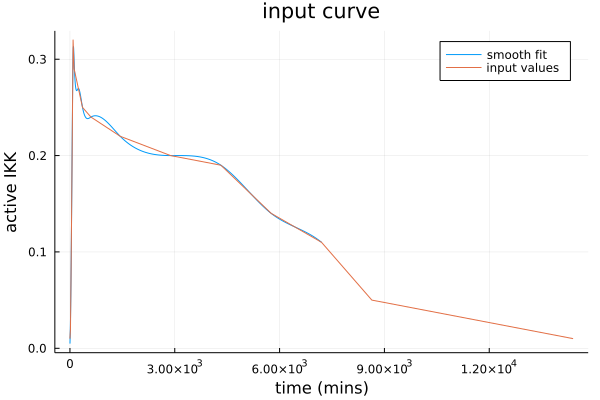

Defined IKK input curve.


In [15]:
################################################
#### define the IKK input function we need #####
################################################
# function ikkDefault(t,maxTime,paramVals,paramTime)
#     #explicitely defined input    
#     #get the value after the current time point
#     indexGTTime=min(searchsortedfirst(paramTime,t),length(paramTime))
#     #get the one before
#     indexLTTime=max(1,indexGTTime-1)
#     timeGTt=paramTime[indexGTTime]
#     timeLTt=paramTime[indexLTTime]
#     valGTt=paramVals[indexGTTime]
#     valLTt=paramVals[indexLTTime]
#     timeDiff=timeGTt-timeLTt
#     #if the time before and time after are different do a basic linear interpolation between the two.
#     if timeDiff>0
#         valDiff=valGTt-valLTt
#         gradient=valDiff/timeDiff
#         timeStep=t-timeLTt
#         return valLTt+(gradient*timeStep)
#     else
#         return valLTt
#     end
# end

X = map(Float64,paramTime)
Y = map(Float64,paramVals)
spl = fit(SmoothingSpline, X, Y,1000.0) # λ=250.0
Ypred = predict(spl,1.0:maxTimeTC) # fitted vector
p=plot(Ypred,label="smooth fit",title="input curve")
plot!(paramTime,paramVals,label="input values")
xlabel!("time (mins)")
ylabel!("active IKK")
display(p)
#the IKK function is just maps to basal IKK during SS and basal+the IKK curve during the time course.
ikkSS=t->basalIKK
ikkTC=t->basalIKK+(maximum([predict(spl,t),0])*IKKMultiplier*totalIKK);
println("Defined IKK input curve.")

In [16]:
################################################
### Create a combined model from the modules ###
################################################
#first lets tell Julia where the files are
modulesToInclude=["NFkB","cellCycle","apoptosis","differentiation"]
linkingModuleName="linking"
combinedModelLocation="combinedModelDefinitionFiles/"
mkpath(combinedModelLocation)


#first lets load the linking file so we know to skip any reactions 
#which are doubly described by the linking file and one of the modules
linkingReactions=""
if(delay)
    linkingReactions = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/reactions_withDelay.csv"))
else
    linkingReactions = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/reactions.csv"))
end
linkingParameters = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/parameters.csv"))
linkingrateLaws = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/rateLaws.csv"))

#missing values mess things up so replace with empty strings
replace!(linkingReactions.Substrate, missing => "")
replace!(linkingReactions.Products, missing => "")

#we know we need all the linking reactions in the combined model
reactionsCombined=linkingReactions
parametersCombined=linkingParameters
rateLawsCombined=linkingrateLaws
# loop through each model
for mod in modulesToInclude
    print("adding $(mod) module\n")
    
    thisModule=moduleDefinitionFilesFolder*mod
    #the NFkB file can have delays but the rest do not
    reactionFile=""
    if mod=="NFkB" && delay
        reactionFile=thisModule*"/reactions_withDelay.csv"
    else
        reactionFile=thisModule*"/reactions.csv"
    end
    parameterFile=thisModule*"/parameters.csv"
    rateLawsFile=thisModule*"/rateLaws.csv"
    
    parameterDF = DataFrame(CSV.File(parameterFile,types=Dict(:parameter=>String, :value=>String, :distrbute=>Int64)))
    rateLawDF = DataFrame(CSV.File(rateLawsFile))
    reactionDF = DataFrame(CSV.File(reactionFile))
    #not every entry in the reaction database is filled in and missing data can cause a problem
    replace!(reactionDF.Substrate, missing => "")
    replace!(reactionDF.Products, missing => "")
    
    #keep track of rows to remove
    #these are rows that appear in individual module reaction files 
    #and are replaced by reactions in the linking module.
    rowsToRemove=[]
    thisRow=1
    for row in eachrow(reactionDF)
        if nrow(linkingReactions[(linkingReactions[!,"Substrate"].==row.Substrate).&(linkingReactions[!,"Products"].==row.Products),:])>0
            print("removing: $(row.Substrate) -> $(row.Products) as it is included in linking file\n")
            push!(rowsToRemove,thisRow)
        end
        thisRow=thisRow+1
    end
    delete!(reactionDF, rowsToRemove)
    print("adding module $(mod) to combined reaction array\n")
    
    #we need to append a module ID on each parameter name in the reactions file 
    #because some parameters have the same name in multiple modules
    theseParams=reactionDF.Parameters
    replacementParams=""
    newParams=theseParams
    thisLine=1
    for param in theseParams
        eachParam=split(param," ")
        eachParam=[i*"-"*mod for i in eachParam]
        replacementParams=join(eachParam," ")
        newParams[thisLine]=replacementParams
        thisLine=thisLine+1
    end
    reactionDF.Parameters=newParams
    append!(reactionsCombined,reactionDF)
    
    #do the same prepending in the parameters file for the combined model
    parameterDF = CSV.read(parameterFile,DataFrame,types=Dict(:parameter=>String, :value=>String, :distrbute=>Int64))
    theseParams=parameterDF.parameter
    parameterDF.parameter=parameterDF.parameter.*("-"*mod)

    append!(parametersCombined,parameterDF)

    #rate law duplication seems ok and unambiguous for now
    rateLawsDF=CSV.read(rateLawsFile,DataFrame;type=String)
    append!(rateLawsCombined,rateLawsDF)

    print("finished $(mod)\n\n")
end
#write out the combined model
CSV.write(combinedModelLocation*"reactions.csv", reactionsCombined)
CSV.write(combinedModelLocation*"parameters.csv", parametersCombined)
CSV.write(combinedModelLocation*"rateLaws.csv", rateLawsCombined)
print("finished combining all modules\n")

adding NFkB module
removing:  -> tcRel as it is included in linking file
removing: RelA ->  as it is included in linking file
removing: cRel ->  as it is included in linking file
adding module NFkB to combined reaction array
finished NFkB

adding cellCycle module
removing:  -> GM as it is included in linking file
removing:  -> Mass as it is included in linking file
removing:  -> cycD as it is included in linking file
adding module cellCycle to combined reaction array
finished cellCycle

adding apoptosis module
removing:  -> L as it is included in linking file
removing: L ->  as it is included in linking file
removing: L ->  as it is included in linking file
adding module apoptosis to combined reaction array
finished apoptosis

adding differentiation module
removing:  -> IRF4 as it is included in linking file
removing:  -> cRel as it is included in linking file
removing: cRel ->  as it is included in linking file
removing:  -> RelA as it is included in linking file
removing: RelA ->  as

In [17]:
################################################
###### Create distributed starting states ######
################################################
if distribute
    #reload parameter file from CSV
    parametersFile = DataFrame(CSV.File(combinedModelLocation*"parameters.csv",types=Dict(:parameter=>String, :value=>String, :distrbute=>Int64)))
    thisDist=TruncatedNormal(1.0, preCV,0,Inf)
    mkpath(distributedCombinedModelLocation)
    #for every starting cell required
    for i in 1:numCells
        thisParams=deepcopy(parametersFile)
        #loop through every parameter and determine if it is meant to be distirbuted
        for j in 1:size(thisParams,1)
            if thisParams[j,3]==1
                x = rand(thisDist, 1)
                #
                oldParam=parse(Float64,thisParams[j,2])
                thisParams[j,2]=string(oldParam.*x[1])
            end
        end
        #now write this cell's CSV file to a folder of cells
        CSV.write(distributedCombinedModelLocation*"parameters_cell_"*string(i)*".csv", thisParams)
    end
    @info("Distributed starting parameters for "*string(numCells)*" cells, and saved in : "*distributedCombinedModelLocation*"\n");flush(io)
    println("Finished distributing all parameters\n")
else
    println("Parameter distribution not requeste\n")
    @info("Parameter distribution not requested \n");flush(io)
end

Finished distributing all parameters



In [24]:
################################################
############### build the model(s) #############
################################################
if distribute
    mkpath("distributedModelFiles/")
    mkpath("modelFiles/")

    for i in 1:numCells
        #identify the three CSV sheets that describe the model
        reactionsFile=combinedModelLocation*"reactions.csv"
        parametersFile=distributedCombinedModelLocation*"parameters_cell_"*string(i)*".csv"
        rateLawsFile=combinedModelLocation*"rateLaws.csv"
        #build a command to execute csv2julia
        location=[locationOfCSV2Julia]
        arguments=[reactionsFile, parametersFile, rateLawsFile,"odeMultiscaleModel.jl"]
        cmd=`python3 $locationOfCSV2Julia $arguments`

        #lets run csv2julia (requires python to be installed)
        run(cmd)

        #fix the death ligand concentration
        include("variableNames.jl")
        indexOfLigand=findfirst(x->"L"==x,syms)
        fixSpecies("odeMultiscaleModel.jl","odeMultiscaleModel.jl",indexOfLigand)

        #pop the outputs in a modelFiles folder
        mv("odeMultiscaleModel.jl","distributedModelFiles/odeMultiscaleModel_cell_"*string(i)*".jl", force=true)
        
    end
    mv("variableNames.jl","modelFiles/variableNames.jl", force=true);
else
    mkpath("modelFiles/")
        
    #identify the three CSV sheets that describe the model
    reactionsFile=combinedModelLocation*"reactions.csv"
    parametersFile=combinedModelLocation*"parameters.csv"
    rateLawsFile=combinedModelLocation*"rateLaws.csv"


    #build a command to execute csv2julia
    location=[locationOfCSV2Julia]
    arguments=[reactionsFile, parametersFile, rateLawsFile,"odeMultiscaleModel.jl"]
    cmd=`python3 $locationOfCSV2Julia $arguments`

    #lets run csv2julia (requires python to be installed)
    run(cmd)

    
    #fix the death ligand concentration
    include("variableNames.jl")
    indexOfLigand=findfirst(x->"L"==x,syms)
    fixSpecies("odeMultiscaleModel.jl","odeMultiscaleModel.jl",indexOfLigand)

    #pop the outputs in a modelFiles folder
    mv("odeMultiscaleModel.jl","modelFiles/odeMultiscaleModel.jl", force=true)
    mv("variableNames.jl","modelFiles/variableNames.jl", force=true);
end

Opening combinedModelDefinitionFiles/rateLaws.csv as rate law file
Opening distrbutedCombinedModelDefinitionFiles/parameters_cell_1.csv as parameters file
Opening combinedModelDefinitionFiles/reactions.csv as reactions file
Opening combinedModelDefinitionFiles/rateLaws.csv as rate law file
Opening distrbutedCombinedModelDefinitionFiles/parameters_cell_2.csv as parameters file
Opening combinedModelDefinitionFiles/reactions.csv as reactions file
Opening combinedModelDefinitionFiles/rateLaws.csv as rate law file
Opening distrbutedCombinedModelDefinitionFiles/parameters_cell_3.csv as parameters file
Opening combinedModelDefinitionFiles/reactions.csv as reactions file
Opening combinedModelDefinitionFiles/rateLaws.csv as rate law file
Opening distrbutedCombinedModelDefinitionFiles/parameters_cell_4.csv as parameters file
Opening combinedModelDefinitionFiles/reactions.csv as reactions file
Opening combinedModelDefinitionFiles/rateLaws.csv as rate law file
Opening distrbutedCombinedModelDefini

"modelFiles/variableNames.jl"

In [25]:
################################################
########## Load the initial conditions #########
################################################
include("modelFiles/variableNames.jl")
InitConds=zeros(length(syms),1)
#initial conditions for NFkB model are loaded from individual model run in other sheet (RunModels.ipynb)
nfkbSS=CSV.read(nfkbSSFile,DataFrame)
for i=1:size(nfkbSS,1)
    indexOfThisVar=findfirst(x->nfkbSS[i,1]==x,syms)    
    InitConds[indexOfThisVar]=nfkbSS[i,2]
end

#initial conditions from the apoptosis model are loaded from the previous runs
apopSS=CSV.read(apoptosisFile,DataFrame)
for i=1:size(apopSS,1)
    indexOfThisVar=findfirst(x->apopSS[i,1]==x,syms)    
    InitConds[indexOfThisVar]=apopSS[i,2]
end

#set cPARP = 0 however the previous model finished.
indexOfCPARP=findfirst(x->"CPARP"==x,syms)
InitConds[indexOfCPARP]=0;

#need to load the linking and cell cycle init conditions, using a file for this now to ensure consistency
InitCondCSV=CSV.read(linkingFile,DataFrame)
for i=1:size(InitCondCSV,1)
    indexOfThisVar=findfirst(x->InitCondCSV[i,1]==x,syms)    
    InitConds[indexOfThisVar]=InitCondCSV[i,2]
end

#all initial conditions loaded, saving to a CSV file for future reference.
df=DataFrame(InitConds,:auto)
insertcols!(df, 1, :names=>syms)
mkpath("outputFiles/")
CSV.write("outputFiles/initialConditions.csv",df);

println("Initial conditions loaded")

Initial conditions loaded


In [26]:
################################################
###### find important indexes in advance #######
################################################
indexOfRb=findfirst(x->"Rb"==x,syms)
indexOfE2FRb=findfirst(x->"E2F_Rb"==x,syms)
indexOfpE2FRb=findfirst(x->"pE2F_Rb"==x,syms)
indexOfHypoPRb=findfirst(x->"HypoP_Rb"==x,syms) 
indexOfSwitch=findfirst(x->"r31switch"==x,syms)
indexOfCdh1=findfirst(x->"Cdh1"==x,syms)
indexOfFateSwitch=findfirst(x->"fateSwitch"==x,syms)
indexOfCPARP=findfirst(x->"CPARP"==x,syms)
indexOfMass=findfirst(x->"Mass"==x,syms)
indexOfGM=findfirst(x->"GM"==x,syms)
indexOfIRF4=findfirst(x->"IRF4"==x,syms)
indexOfAID=findfirst(x->"AID"==x,syms)
indexOfBlimp1=findfirst(x->"Blimp1"==x,syms)
indexOfPax5=findfirst(x->"Pax5"==x,syms)
indexOfBcl6=findfirst(x->"Bcl6"==x,syms)
symsSymbol=Symbol.(syms)
println("Identified indexes of key species needed later")

Identified indexes of key species needed later


In [27]:
################################################
########### define all the callbacks ###########
################################################
#first lets define the switch event for the cell cycle ribosome usage.
function condition(cellcycle,t,integrator) # Event when event_f(u,t) == 0
    #include("modelFiles/variableNames.jl")
    #numberator: Rb + E2F:Rb +  pE2F:Rb
    #denominator: Rb + E2F:Rb +  pE2F:Rb + hypophosphorylated Rb
    numerator= cellcycle[indexOfRb]+cellcycle[indexOfE2FRb]+cellcycle[indexOfpE2FRb];  #ACTIVE RB
    denominator = numerator+cellcycle[indexOfHypoPRb]; #TOTAL RB

    #GM growth (biosynthesis of ribosomes and all necessary machinery)
    #previous iterations had numerator/denominator<0.8
    #diffEq.jl requires a function that hits 0
    (numerator/denominator)-0.8
end
function affect!(integrator)
  #update r31Switch to 1
  integrator.u[indexOfSwitch] = 0
end
function affectNeg!(integrator)
  #update r31Switch to 1
  integrator.u[indexOfSwitch] = 1
end

# now lets define the cell division event
function conditionCdh(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      #include("modelFiles/variableNames.jl")
      #triggers when Cdh1 crosses 0.2 in the positive direction
      cellcycle[indexOfCdh1]-0.2
end
#in multiscale modeling this should introduce two new simulations, but for now lets just divide this one cell
function affectCdh!(integrator)
  #print("cell divided - callback\n")
  integrator.uprev[indexOfFateSwitch]=1 #division
  integrator.u[indexOfFateSwitch]=1
  #step!(integrator)
  terminate!(integrator)
end

#now lets define the cell death events
function conditionCPARP(species,t,integrator) # Event when event_f(u,t) == 0 

      #triggers when Cdh1 crosses 0.2 in the positive direction
      species[indexOfCPARP]-2500
end
#in multiscale modeling this should introduce two new simulations, but for now lets just divide this one cell
function affectCPARP!(integrator)
  #uncomment the below lines to restore death, made cells immortal for testing
  #kill the cell and the integration
  integrator.uprev[indexOfFateSwitch]=2 #death
  integrator.u[indexOfFateSwitch]=2
  #step!(integrator)    
  terminate!(integrator)
end

function affectCdhNoNewCells!(integrator)
  #this clalback will divide the concentrations but not terminate the integrator to create new cells
  #triggers when Cdh1 crosses 0.2 in the positive direction
  #update Mass to 0.5* mass
  #integrator.u[indexOfMass] = 0.5*integrator.u[indexOfMass]
  #Gm to 0.5 * Gm
  #integrator.u[indexOfGM]=0.5*integrator.u[indexOfGM]
  #update everything to 0.5* previous concentrations
  integrator.u=0.5.*integrator.u
  integrator.u[indexOfSwitch]=1  
  integrator.u[indexOfCdh1]=1.0   #required to prevent it dividing again very quickly. this is done in shokhirev et al.
end

#use and combine the callbacks described above to trigger events
cb = ContinuousCallback(condition,affect!,affectNeg!,save_positions=(true,true))
cb2 = ContinuousCallback(conditionCdh,affectCdh!,nothing,save_positions=(true,true))
cb3 = ContinuousCallback(conditionCPARP,affectCPARP!,nothing,save_positions=(true,true))
cb4 = ContinuousCallback(conditionCdh,affectCdhNoNewCells!,nothing,save_positions=(true,true))
cbs=CallbackSet(cb,cb2,cb3);
cbNoDivision=CallbackSet(cb,cb3); #used when we don't want cells to divide
cbSteadyState=CallbackSet(cb,cb4); #used in initial stage where we want division but not to create new cells
println("All callbacks defined")

All callbacks defined


In [28]:
################################################
#### define what to do when cells divide #######
################################################
function cellDivision!(sol,f,ikkTC,maxTimeTC,cbs,gen,cells,birthTime,yCoord,syms,delay)
  message="Cell divided yCoord: "*string(yCoord)*". gen:"*string(gen)*". birthTime:"*string(birthTime)*".\n"
  @info(message)
  flush(io)
  # use indexes defined above
  global indexOfMass
  global indexOfGM
  global indexOfSwitch
  global indexOfFateSwitch
  global indexOfCdh1
  global indexOfCPARP

  #update everything to 0.5* previous concentrations
  uNew=sol[end]
  uNew[uNew.<0].=0
  uNewLeft,uNewRight = sampleInit(uNew,divCV)
  uNewLeft=uNewLeft.*0.5
  uNewRight=uNewRight.*0.5
  uNewLeft[indexOfSwitch]=1
  uNewRight[indexOfSwitch]=1
  uNewLeft[indexOfFateSwitch]=0
  uNewRight[indexOfFateSwitch]=0
  uNewLeft[indexOfCPARP]=0
  uNewRight[indexOfCPARP]=0
  uNewLeft[indexOfCdh1]=1.0   #required to prevent it dividing again very quickly. this is done in shokhirev et al.
  #lets create two new cells whos starting conditions are half of the previous cell. 
  uNewRight[indexOfCdh1]=1.0
    
  if(delay)
      histLeft(p,t)=uNewLeft
      histRight(p,t)=uNewRight
  else
      histLeft=nothing
      histRight=nothing
  end

  t1=@spawn runCell(syms,f,uNewLeft,ikkTC,maxTimeTC,cbs,gen+1,cells,birthTime,yCoord+(plotSpacing/(gen^2+1)),histLeft,delay)  
  t2=@spawn runCell(syms,f,uNewRight,ikkTC,maxTimeTC,cbs,gen+1,cells,birthTime,yCoord-(plotSpacing/(gen^2+1)),histRight,delay)
  fetch(t1)
  fetch(t2)
end
println("Cell division function created")

Cell division function created


In [29]:
################################################
##### define the main run cell function ########
################################################
# let's define a function to run cells so that we can put each new cell into a new thread.
function runCell(syms,f,y0,ikkTC,maxTimeTC,cbs,gen,cells,startTime,yCoord,hist,delay)
    message="new cell gen: "*string(gen)*". startTime:"*string(startTime)*"\n"
    @info(message); flush(io)
    maxTimeTC=float(maxTimeTC)
    startTime=float(startTime)
    global indexOfCdh1
    global indexOfCPARP
    global indexOfFateSwitch
    global mechanicalDeathTime
    global startGen
    symsSymbol=Symbol.(syms)

    if delay
        prob=DDEProblem(f,y0,hist,(startTime,maxTimeTC),ikkTC)
    else
        prob=ODEProblem(f,y0,(startTime,maxTimeTC),ikkTC)
    end
    
    #we need to run a cell with no division if it has reached max generations
    if(gen<maxGens)
        message="running cell, yCoord:"*string(yCoord)*" generation ("*string(gen)*") is not last\n"
        @info(message); flush(io)
        
        timingVar=@timed sol = solve(prob,Rodas4(autodiff=false),callback=cbs)
        
        message="solution for cell, yCoord:"*string(yCoord)*" returned  in: "*string(timingVar.time)*" seconds \n"
        @info(message); flush(io)
    else
        message="final generation. running new cell without division, gen: "*string(gen)*".\n"
        @info(message); flush(io)
        sol=solve(prob,Rodas4(autodiff=false),callback=cbNoDivision,)
    end
    if sol.retcode==:Success
        message="cell : yCoord: "*string(yCoord)*" reached end state without an event at time: "*string(sol.t[end])*", gen: "*string(gen)*".\n"
        @info(message); flush(io)
    elseif sol.retcode==:Terminated
        message="cell : yCoord: "*string(yCoord)*" reached an event at time: "*string(sol.t[end])*", gen: "*string(gen)*".\n"
        @info(message); flush(io)
    else
        message="cell : yCoord: "*string(yCoord)*" FAILED with retcode: "*string(sol.retcode)*" at time: "*string(sol.t[end])*", gen: "*string(gen)*". Saving solution to csv file to examine later\n"
        @info(message); flush(io)
        sol.t[end]
        
        df=DataFrame(sol)
        CSV.write("failedCell-"*string(yCoord)*".csv",df)
        println("a cell has failed, do not trust results and check for failedCell.csv file to determine the problem")
    end
    #now lets update the plot and output files
    intGen=convert(Int64,gen)
    intStartTime=max(convert(Int64,round(startTime, digits=0)),1)
    intEndTime=convert(Int64,round(sol.t[end], digits=0))
    message="launching update plot with start Time: "*string(startTime)*", endTime: "*string(sol.t[end])*", yCoord: "*string(yCoord)*", gen: "*string(gen)*".\n"
    @info(message); flush(io)
    
        
    #lets figure out whether the cell divided or died and create new cells if it divide
    fate=sol[end][indexOfFateSwitch]
    
    #check if cell died very soon and try again if it did
    if (fate==2) && (gen==startGen) && (sol.t[end]<mechanicalDeathTime)
        return false
    end

    try
        updatePlotToCSV(startTime,sol.t[end],yCoord,gen,fate)
    catch err
        @info("couldn't update plot: "*string(err)*"\n");flush(io)
    end
    
    #if cell divided trigger cellDivision... otherwise do nothing.
    if (fate==1)      
        @info("Cell divided at time: "*string(sol.t[end])*", ycoord:"*string(yCoord)*".\n");flush(io)
        birthTime=sol.t[end]
        cellDivision!(sol,f,ikkTC,maxTimeTC,cbs,gen,cells,birthTime,yCoord,syms,delay)

    elseif(fate==2)
            @info("Cell died at time: "*string(sol.t[end])*".\n"); flush(io)
    end
    #append!(cells,sol)
    #return sol #not sure we actually use this at the moment
    return true
end
println("runCell function created")


runCell function created


In [30]:
################################################
#### update the output file for plotting #######
################################################
function updatePlotToCSV(startTime,endTime,yCoord,gen,fate)
    @info("running update plot\n");flush(io)
    global thisColorPalette
    #updates the plot
    
    #we build an array to write to the CSV file which contains all lines that need to be added to the lineage graph and their colours
    toWriteGraph=[startTime endTime yCoord yCoord thisColorPalette[gen].r thisColorPalette[gen].g thisColorPalette[gen].b]
    
    thisFate="?"
    
    # first we write to the cellCounts file, which shos how many cells we had of each generation
    try
        toWriteCellCounts=zeros(1,Int64(round(maxTimeTC)))
        toWriteCellCounts[Int64(round(startTime)):Int64(round(endTime))].=(1*gen)
        CSV.write("cellCounts.csv",  Tables.table(toWriteCellCounts), writeheader=false, append=true, newline='\n')
        message="cellCounts.csv updated between: "*string(Int64(round(startTime)))*", and: "*string(Int64(round(endTime)))*", with "*string((1*gen))*"\n"
        @info(message); flush(io)
    catch err
        @info("couldn't write to cellCounts.csv "*string(err)*"\n"); flush(io)
    end
    
    # if this is a divided cell we need to draw a verticle line between the lineages
    if fate==1 #this is a division event vertical line
        thisFate="division"

        message="ycoord: "*string(yCoord)*" fate: division at time "*string(endTime)*"\n"
        @info(message)
        flush(io)
     
        toWrite=[endTime endTime yCoord-(plotSpacing/(gen^2+1)) yCoord+(plotSpacing/(gen^2+1)) 0.0 0.0 0.0]
        toWriteGraph=[toWriteGraph;toWrite]
     
    elseif fate==2 #this is a death event
        #if this is a dead cell we draw a cross at the end of its lineage
        thisFate="death"
        
        message="ycoord: "*string(yCoord)*" fate: death at time "*string(endTime)*"\n"
        @info(message);flush(io)
        
        toWrite=[endTime-crossSize endTime+crossSize yCoord+crossSize yCoord-crossSize thisColorPalette[gen].r thisColorPalette[gen].g thisColorPalette[gen].b;[endTime-crossSize endTime+crossSize yCoord-crossSize yCoord+crossSize thisColorPalette[gen].r thisColorPalette[gen].g thisColorPalette[gen].b]]
        toWriteGraph=[toWriteGraph;toWrite]

    else
        #there was an error solving this cell
    end
    
    @info("Adding "*string(size(toWriteGraph,1))*" lines to graph as cell had fate: "*thisFate*"\n"); flush(io)
    CSV.write("graphStructure.csv",  Tables.table(toWriteGraph), writeheader=false, append=true)
end
println("updatePlotToCSV function created")

updatePlotToCSV function created


In [31]:
###############################################
##### initialise the cells and start sim #######
################################################
function runFirstCellsBasic!(cells,numCells,sol,delay,distribute)
    global indexOfCPARP
    global indexOfCdh1
    global preConcCV
    
    for i in 1:numCells
        @info("Spawning cell "*string(i)* ".\n"); flush(io) 
        thisInit=sol[:,i] #gets the right initial condition for this cell
        
        if distribute
            include("distributedModelFiles/odeMultiscaleModel_cell_"*string(i)*".jl")
        else
            include("modelFiles/odeMultiscaleModel.jl")
        end
        
        if delay
            eqnFile=ddeFile
            hist(p,t)=thisInit 
            f=DDEFunction(eqnFile,syms=symsSymbol)
        else
            eqnFile=odeFile
            hist = nothing
            f=ODEFunction(eqnFile,syms=symsSymbol)
        end
           #create an ODE problem if delay is false, otherwise a DDE problem

    
        
        startTime=1
        ycoord=i*(plotSpacing*3)
        thread=@spawn runCell(syms,f,thisInit,ikkTC,maxTimeTC,cbs,startGen,cells,startTime,ycoord,hist,delay)
        success=fetch(thread)
        maxAttempts=20
        thisAttempt=1
        while (!success) && (thisAttempt<=maxAttempts)
            @info("Attempt "*string(thisAttempt)*" to spawn cell "*string(i)* " failed as it died straight away, trying again with new init conds.\n")
            flush(io)
            thisInit,nothing = sampleInit(thisInit,preConcCV)
            thread=@spawn runCell(syms,f,thisInit,ikkTC,maxTimeTC,cbs,startGen,cells,startTime,ycoord,hist,delay)
            success=fetch(thread)
            thisAttempt=thisAttempt+1
        end
        @info("cell "*string(i)* " spawned.\n")
        flush(io)
    end
    @info("All founder cellls spawned.\n")
    flush(io)
end
println("runFirstCellsBasic function created")

runFirstCellsBasic function created


In [32]:
# ################################################
# ##### initialise the cells and start sim #######
# ################################################
# function runFirstCellsBasic!(cells,numCells,sol,delay,distribute)
#     global indexOfCPARP
#     global indexOfCdh1
    
#     for i in 1:numCells
#         @info("Spawning cell "*string(i)* ".\n"); flush(io) 
#         thisInit=sol[:,rand(1:end)] #gets a random initial condition from along the time course so cells aren't synchronised
#         @info("Random initial point on time course selected for cell: "*string(i)* ".\n"); flush(io)        
        
#         if distribute
#             include("distributedModelFiles/odeMultiscaleModel_cell_"*string(i)*".jl")
#         else
#             include("modelFiles/odeMultiscaleModel.jl")
#         end
        
#         if delay
#             eqnFile=ddeFile
#             hist(p,t)=thisInit 
#             f=DDEFunction(eqnFile,syms=symsSymbol)
#         else
#             eqnFile=odeFile
#             hist = nothing
#             f=ODEFunction(eqnFile,syms=symsSymbol)
#         end
#            #create an ODE problem if delay is false, otherwise a DDE problem

    
        
#         startTime=1
#         ycoord=i*(plotSpacing*3)
#         thread=@spawn runCell(syms,f,thisInit,ikkTC,maxTimeTC,cbs,startGen,cells,startTime,ycoord,hist,delay)
#         fetch(thread)
#         @info("cell "*string(i)* " spawned.\n")
#         flush(io)
#     end
#     @info("All founder cellls spawned.\n")
#     flush(io)
# end
# println("runFirstCellsBasic function created")

In [33]:
function generateProb(delay, eqnFile,y0,preSimTime,ikkSS)
    global symsSymbol
    if delay
        f=DDEFunction(eqnFile,syms=symsSymbol)
        h(p,t)=y0
        prob=DDEProblem(f,y0,h,(0.0,preSimTime),ikkSS)
    else
        f=ODEFunction(eqnFile,syms=symsSymbol)
        prob=ODEProblem(f,y0,(0.0,preSimTime),ikkSS)
    end
    return prob
end

generateProb (generic function with 1 method)

In [34]:
################################################
######## Run a pre-sim if requested ############
################################################
### if it's distributed lets select the first cell for pre-sim
eqnArray=[];
if distribute
    for i in 1:numCells
        include("distributedModelFiles/odeMultiscaleModel_cell_"*string(i)*".jl")
        if delay
            eqnFile=ddeFile
        else
            eqnFile=odeFile            
        end
        eqnArray=[eqnArray;eqnFile]
    end
else
    include("modelFiles/odeMultiscaleModel.jl")
    if delay
        eqnFile=ddeFile
    else
        eqnFile=odeFile            
    end
end
probArray=[];
if distribute 
    for i in 1:numCells
        probArray=[probArray; generateProb(delay,eqnArray[i],InitConds,preSimTime,ikkSS)]
    end
else
    ### generate the problem object
    ### we'll pre-sim for a random time.
    prob=generateProb(delay,eqnFile,InitConds,rand(1:preSimTime),ikkSS)
    probArray=[probArray;prob]
    ### solve a pre time course if necessary
end
initSol=zeros(size(InitConds,1),numCells)
if runPreCourse
    if distribute
        println("Pre-simulating time courses for all individual cells")
        for i in 1:size(InitConds,1)
            @info("Simulating a pre time-course for cell "*string(i)*"\n");flush(io)
            thisSol=solve(probArray[i],Rodas4(),callback=cbSteadyState)
            @info("Pre simulation time-course for cell "*string(i)*" complete\n");flush(io)
            initSol[:,i]=thisSol[end]
            initSol[indexOfCPARP,i]=0
            initSol[indexOfCdh1,i]=1
            initSol[indexOfIRF4,i]=0
            initSol[indexOfAID,i]=0
            initSol[indexOfBlimp1,i]=0
            initSol[indexOfPax5,i]=1
            initSol[indexOfBcl6,i]=0
            
            
        end
        println("pre-simulating time course complete for all cells")

        @info("All pre-simulation complete\n");flush(io)

    else
        @info("Simulating a pre time-course for a single cell\n");flush(io)
        thisSol=solve(probArray[1],Rodas4(autodiff=false),callback=cbSteadyState)
        initSol=thisSol[end-numCells:end]
        println("pre-simulating time course complete")
        @info("pre-simulation complete\n");flush(io)
    end
else
    initSol=repeat(InitConds,1,numCells)
    for i in 1:numCells
        distInit,nothing = sampleInit(initSol[:,i],preConcCV)
        initSol[:,i]=distInit
    end
    initSol[indexOfCPARP,:].=0
    initSol[indexOfCdh1,:].=1
    initSol[indexOfIRF4,:].=0
    initSol[indexOfAID,:].=0
    initSol[indexOfBlimp1,:].=0
    initSol[indexOfPax5,:].=1
    initSol[indexOfBcl6,:].=0
    println("cell initial conditions sampled rather than pre-timecourse")
    @info("cell initial conditions sampled rather than pre-timecourse\n");flush(io)
end


cell initial conditions sampled rather than pre-timecourse


In [35]:
# ################################################
# ######## Run a pre-sim if requested ############
# ################################################
# ### if it's distributed lets select the first cell for pre-sim
# if distribute
#     include("distributedModelFiles/odeMultiscaleModel_cell_1.jl")
# else
#     include("modelFiles/odeMultiscaleModel.jl")
# end
# ### if delayed we have a dde file
# if delay
#     eqnFile=ddeFile
# else
#     eqnFile=odeFile            
# end
# ### generate the problem object
# prob=generateProb(delay,eqnFile,InitConds,preSimTime,ikkSS)
# ### solve a pre time course if necessary

# if runPreCourse
#     @info("Simulating a pre time-course\n");flush(io)
#     initSol=solve(prob,Rodas4(),callback=cbSteadyState)
#     println("pre-simulating time course complete")
#     @info("pre-simulation complete\n");flush(io)
# else
#     initSol=repeat(InitConds,1,preSimTime)
#     println("all cells will start at same point")
#     @info("All cells given same initial condition\n");flush(io)
# end


In [36]:
################################################
############ Run the simulation ################
################################################
@info("initialising "*string(numCells)* " founder cells.\n");flush(io)
println("Simulation has started, you probably now want to run the plotting code to visualise what is happening.")
println("Godspeed B cells.")
start=time()
runFirstCellsBasic!(cells,numCells,initSol,delay,distribute)
elapsed=time()-start
println("Simulation has finished, total time to complete "*string(numCells)*" lineages was: "*string(elapsed)*" seconds");

Simulation has started, you probably now want to run the plotting code to visualise what is happening.
Godspeed B cells.
Simulation has finished, total time to complete 5lineages was: 89.87147498130798 seconds
